<h1>Spam Detection</h1>


In [78]:
from google.colab import files

uploaded = files.upload()


Saving spam.csv to spam (4).csv


Import Necessary Libaries

In [79]:
# Import necessary libraries

import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report


Load the data

In [80]:
# Load the data
spam_df = pd.read_csv('spam.csv', encoding='latin1')
spam_df = spam_df[['v1', 'v2']]
spam_df.columns = ['label', 'message']

# Display the first few rows of the DataFrame
spam_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h2>Data Exploration</h2>

Summary Data

In [81]:
# Summary of the dataset
spam_df.info()

# Basic statistical details
spam_df.describe()

# Display unique labels
unique_labels = spam_df['label'].unique()
print("Unique labels in the dataset:", unique_labels)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
Unique labels in the dataset: ['ham' 'spam']


<h3>Label</h3>

Ham:
* Ham refers to emails or messages that are not spam.
* These are legitimate messages that the user intends to receive.
*The term "ham" was adopted as a counterpart to "spam" to denote non-spam emails in a catchy way, given that both are popular food items, especially in English-speaking countries.
*Examples of ham could include personal correspondence, work-related emails, updates from social networks to which the user has willingly subscribed, and any other messages that the recipient expects and wants.

Spam:

* Spam refers to unsolicited, usually commercial messages sent in bulk over the internet or through any electronic messaging system.
* Spam messages are often irrelevant or inappropriate and are sent to many users, typically for advertising, phishing, spreading malware, etc.
* The term "spam" comes from a Monty Python sketch in which the word is repeated many times, reflecting the repetitive and unwanted presence of spam messages in users' inboxes.
* Examples of spam include emails promoting products that the user did not express interest in, messages asking for personal information under pretences, or any message sent in large volumes without the recipient's consent.

<h2>Data Preprocessing</h2>


<h3>Checking for Missing Data</h3>

<p>Missing data can adversely affect the performance of your model. It's essential to identify and handle any missing values in the dataset.</p>

In [82]:
# Check for missing values
missing_values = spam_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Depending on the outcome, we might have to decide, which drop or fill missing values
spam_df = spam_df.dropna(subset=['message'])


Missing values in each column:
 label      0
message    0
dtype: int64


<p>This result indicates no missing values in our dataset, which is an ideal scenario. Therefore, there is no need for steps like dropping or imputing missing values for this particular dataset. Having all the data simplifies the preprocessing stage. It allows us to proceed to the next steps of data cleaning and text normalization with confidence in the completeness of our data.</p>

<h3>Text Cleaning and Normalization<h3>

<p>This step involves cleaning the text data in the messages and bringing it to a standard format.</p>
<h5>Cleaning</h5>
    <li>Remove unnecessary characters like punctuation, memorable characters, and numbers.</li>
    <li>Convert all text to lowercase for uniformity.</li>
<h5>Normalization</h5>
    <li><b>Tokenization:</b> Breaking down the text into individual words or tokens.</li>
    <li><b>Removing Stop Words:</b> Eliminating common words that do not contribute much to the meaning of the messages.</li>
    <li><b>Stemming/Lemmatization:</b> Reducing words to their base or root form.</li>

In [67]:
nltk.download('punkt')
nltk.download('stopwords')

def clean_and_normalize_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W+|\d+', ' ', text.lower())

    # Tokenization
    words = word_tokenize(text)

    # Removing stopwords and stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('english')]

    return ' '.join(words)

# Apply the function to the message column
spam_df['message'] = spam_df['message'].apply(clean_and_normalize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Text Vectorization</h3>

<p>Once the text is cleaned and normalized, the next step is to convert the text data into a numerical format that machine learning algorithms can work with.</p>

In [68]:
# Vectorizing the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(spam_df['message'])
y = spam_df['label']

<h2>Splitting the Dataset</h2>

<p>Split the dataset into training and testing sets.</p>


In [69]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Creating a new column for message length in the original DataFrame
spam_df['message_length'] = spam_df['message'].apply(len)

<h3> Visualizing Class Distribution in Training and Testing Sets</h3>

This will help us understand if the classes are balanced and if the distribution is similar in both training and testing sets.

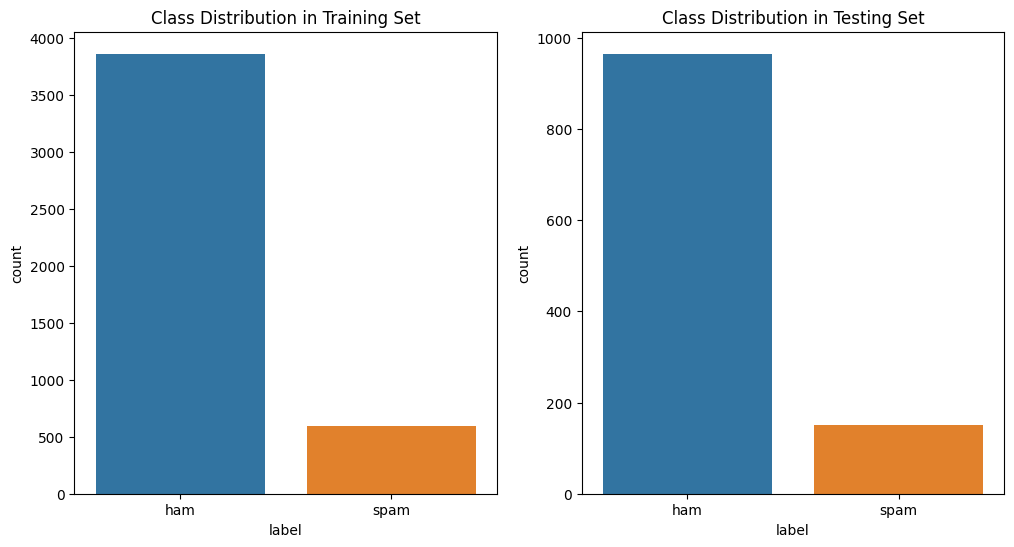

In [70]:
plt.figure(figsize=(12, 6))

# Assuming y_train is a Pandas Series
# If y_train is a numpy array or list, this should still work fine

# Visualizing class distribution in the training set
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set')

# Assuming y_test is also a Pandas Series
# Visualizing class distribution in the testing set
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Class Distribution in Testing Set')

plt.show()


<h4>Observations</h4>

<h5>Training Set Distribution:</h5>

* The first bar graph, labelled "Class Distribution in Training Set," shows a significantly higher number of 'ham' messages than' spam' ones.
* There is a clear imbalance with 'ham' messages outnumbering 'spam' messages, which is typical in real-world scenarios where spam messages are less frequent than non-spam.

<h4>Testing Set Distribution:</h4>

* The second bar graph, "Class Distribution in Testing Set," also displays a similar pattern of class imbalance, with 'ham' messages being more prevalent than 'spam' messages.
* The proportion of 'ham' to 'spam' appears consistent with the training set, suggesting that the split was done stratified, maintaining the overall distribution of the dataset.

<h4>Implications</h4>

<h5>Model Training Considerations:</h5>

* The imbalance in the dataset can influence the performance of machine learning models, potentially leading to a bias towards predicting the majority class ('ham'). This could result in a high accuracy score but poor recall for the minority class ('spam').
* It is crucial to use evaluation metrics that can account for this imbalance, such as the F1-score, precision-recall curves, or the area under the ROC curve, rather than relying solely on accuracy.

<h5>Strategies for Imbalance:</h5>

* Techniques like oversampling the minority class, undersampling the majority class, or using algorithmic approaches to weigh the classes differently during training could be considered to address class imbalance.
* Using more complex models or ensemble methods less sensitive to class imbalance might also be beneficial.

<h5>Testing Set Validity:</h5>


The consistency in distribution between training and testing sets suggests that the testing set validates the real-world scenario and should provide a reliable estimate of the model's performance on unseen data.

<h3>Visualizing Message Length Distribution</h3>

<p>Sometimes the length of the messages can be a feature of interest, particularly in spam detection.</p>

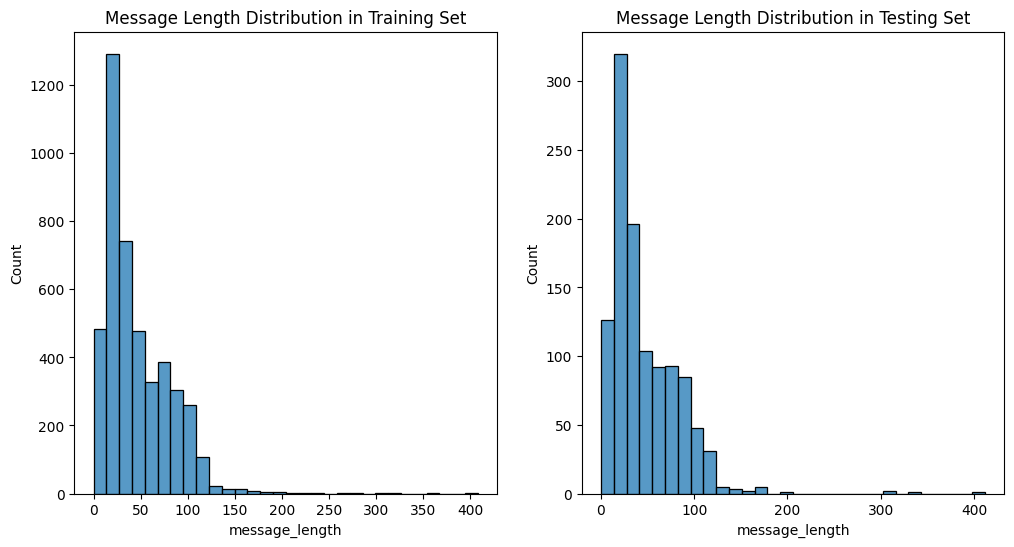

In [71]:
# Creating a new column for message length
spam_df['message_length'] = spam_df['message'].apply(len)

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(spam_df, test_size=0.2, random_state=42)

# Plotting the message length distribution
plt.figure(figsize=(12, 6))

# For the training set
plt.subplot(1, 2, 1)
sns.histplot(train_df['message_length'], bins=30, kde=False)
plt.title('Message Length Distribution in Training Set')

# For the testing set
plt.subplot(1, 2, 2)
sns.histplot(test_df['message_length'], bins=30, kde=False)
plt.title('Message Length Distribution in Testing Set')

plt.show()


<h4>Observations</h4>

1. Skewed Distribution: Both histograms show a right-skewed distribution, meaning that most messages are of shorter length, while fewer messages have a longer length.
2. Training Set:
  * The histogram for the training set indicates that many messages have lengths that fall within the lower range (approximately 0 to 50 characters).
  * There is a noticeable drop as message length increases, with only 200 messages longer than 200 characters.
3. Testing Set:
  * The testing set histogram also shows a similar pattern of message lengths, with most messages being short and very few being long.
  * Compared to the training set, the testing set contains fewer messages overall, which is evident from the lower counts across message lengths. This is expected since the testing set is typically smaller than the training set.

<h2>Model Training</h2>





<h3> Naive Bayes Classifier</h3>

In [72]:
# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

MultinomialNB()

<h4> Naive Bayes Classifier Evaluation</h4>

In [73]:
# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9668161434977578
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

Confusion Matrix:
 [[965   0]
 [ 37 113]]


<h4>Confusion Matrix Heatmap<h4>

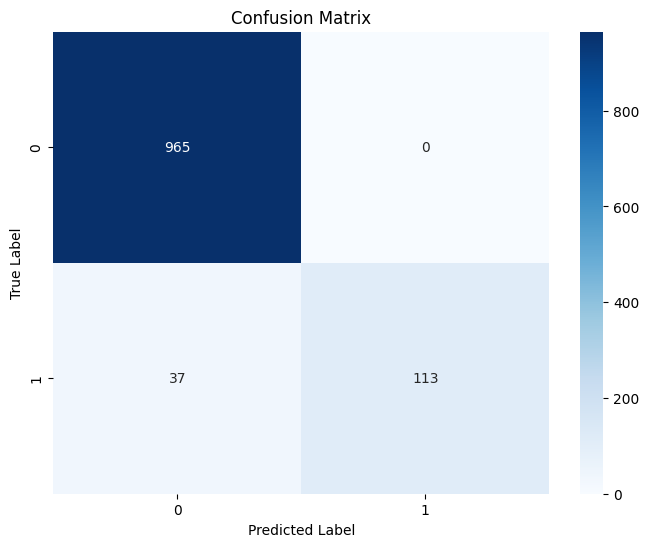

In [74]:
# Assuming y_test and y_pred are already defined
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

* Top-Left (True Negative - TN): The number 965 represents the 'true negatives' - cases where the model correctly predicted the negative class (in this case, 'ham' or non-spam).
* Top-Right (False Positive - FP): 0 indicates no 'false positives' - cases where the model incorrectly predicted the positive class (no non-spam messages were incorrectly labelled as spam).
* Bottom-Left (False Negative - FN): The number 37 represents the 'false negatives' - cases where the model incorrectly predicted the negative class (these spam messages were incorrectly labelled as non-spam).
* Bottom-Right (True Positive - TP): The number 113 indicates the 'true positives' - cases where the model correctly predicted the positive class (these spam messages were correctly identified).

<h4>ROC Curve<h4>

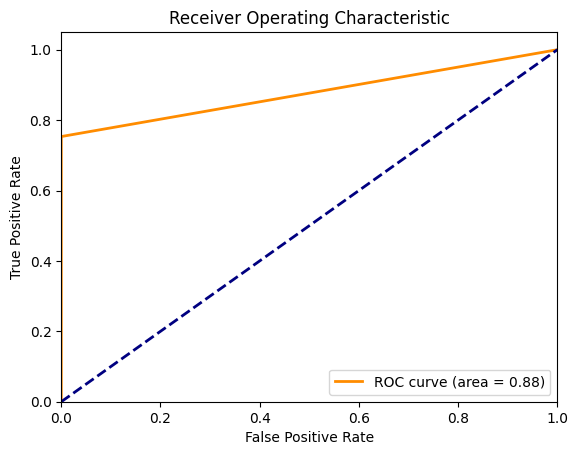

In [75]:
# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=['ham', 'spam'])
y_pred_binarized = label_binarize(y_pred, classes=['ham', 'spam'])

fpr, tpr, thresholds = roc_curve(y_test_binarized, y_pred_binarized)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

* ROC Curve: The orange line represents the ROC curve of the model. The curve shows the trade-off between the TPR and FPR. A perfect model would have a curve that goes straight up the y-axis and then along the x-axis.
* Area Under the Curve (AUC): The area under the ROC curve is 0.88. The AUC value ranges from 0 to 1 and measures the overall performance of a model; the higher the AUC, the better the model is at distinguishing between the positive and negative classes. An AUC of 0.88 is quite good and indicates high separability between 'ham' and 'spam'.
* Dashed Line: The blue dashed line represents a random guess. If the ROC curve exceeds this line, the model performs better than random chance.

<h4>Precision-Recall Curve</h4>

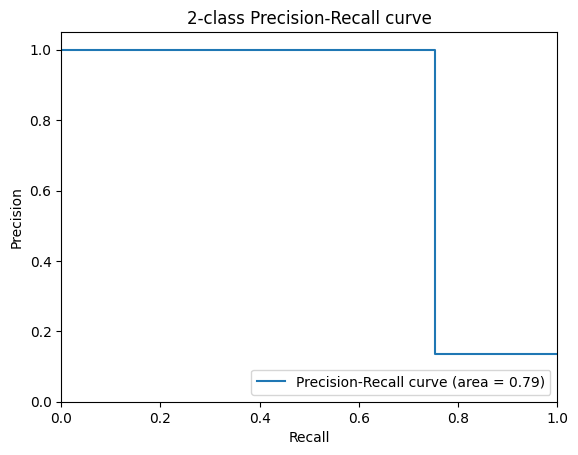

In [76]:
precision, recall, _ = precision_recall_curve(y_test_binarized, y_pred_binarized)
average_precision = average_precision_score(y_test_binarized, y_pred_binarized)

plt.figure()
plt.step(recall, precision, where='post', label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

The Precision-Recall curve is a plot that illustrates the trade-off between precision (the accuracy of the optimistic predictions) and recall (the ability of the classifier to find all the positive samples) for different probability thresholds.
* Precision (y-axis): The ratio of true positives to the sum of true and false positives. It is a measure of a classifier's exactness. High precision indicates a low false positive rate.
* Recall (x-axis): The ratio of true positives to the sum of true and false negatives. It is a measure of a classifier's completeness. High recall indicates a low false negative rate.
* Curve Shape: The ideal shape of a precision-recall curve is a rectangle extending to the top right corner, indicating both high precision and high recall.
* Area Under Curve (AUC): This specific curve has an AUC of 0.79. The AUC for precision-recall curves represents a model's average precision across all recall levels and is exceptionally informative for imbalanced datasets

<h4>Comparative Analysis of Precision-Recall and ROC Curves for Spam Detection Model</h4>

We employed two distinct graphical representations in evaluating our spam detection model: the Precision-Recall curve and the Receiver Operating Characteristic (ROC) curve. The Precision-Recall curve, with an area under the curve (AUC) of 0.79, suggests that the model has a reasonably high average precision across all levels of recall. This indicates that when the model predicts a message as spam, it is correct around 79% of the time. However, the curve's shape also implies that a trade-off is being made; as we increase the threshold to capture more true spam messages (increasing recall), the precision of the model decreases, leading to more false spam identifications.

Conversely, the ROC curve, which has a higher AUC of 0.88, demonstrates the model's effectiveness in distinguishing between the spam and non-spam classes across all thresholds. The ROC curve illustrates that the model has a high true positive rate (sensitivity) for a false positive rate (1-specificity). However, it does not account for the class imbalance in spam detection tasks.

When the class distribution is skewed, the Precision-Recall curve is often more informative than the ROC curve, as it focuses more closely on the model's performance about the less prevalent class — in this case, the spam messages. The fact that the Precision-Recall AUC is lower than the ROC AUC suggests that the class imbalance is impacting the model's performance, and specific efforts may be required to improve the detection of spam messages without misclassifying too many legitimate messages as spam.

In conclusion, while the ROC curve indicates good overall performance, the Precision-Recall curve provides a more nuanced view that highlights potential areas for improvement in the context of an imbalanced dataset. Optimizing the balance between precision and recall should be a focus for enhancing the model's practical effectiveness in spam detection.

<h4>Classification Report</h4>

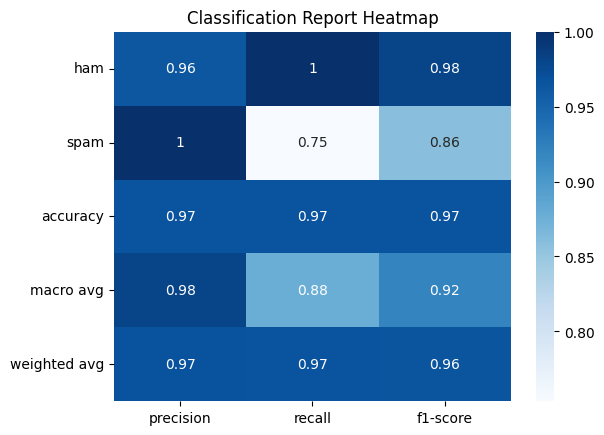

In [77]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="Blues")
plt.title('Classification Report Heatmap')
plt.show()

<h4>Accuracy</h4>

The model has an accuracy of approximately 96.68%, which means that this percentage of the total predictions made by the model is correct.

<h4>Precision</h4>

Of all the predictions the model made for a given class, precision tells us how many were correct.

* For ham, the precision is 0.96, meaning 96% of messages predicted as ham were ham.
* For spam, the precision is 1.00, meaning 100% of messages predicted as spam were spam.

<h4>Recall</h4>

Out of all the actual instances of a given class, recall tells us how many the model correctly predicted.
* For ham, the recall is 1.00, meaning the model correctly identified all ham messages.
* The recall is 0.75 for spam, meaning the model correctly identified 75% of all actual spam messages.

<h4>F1 - Score</h4>

The F1-score is the harmonic mean of precision and recall, balancing the two for each class.
* For ham, the F1-score is 0.98, suggesting a good balance between precision and recall.
* For spam, the F1-score is 0.86, which is slightly lower, indicating that while all spam predictions were correct (precision), the model missed some spam messages (recall).

<h4>Support</h4>

This tells us the number of actual occurrences of each class in the dataset.
* The test set has 965 instances of ham and 150 instances of spam.
